<a href="https://colab.research.google.com/github/shreya27tripathi/vgg16_autism/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import random
import os
import gc

from tensorflow import keras
from keras import layers
from keras import models, Sequential
from keras import optimizers

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D

from keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [2]:
# Creating file path for our train data and test data
train_dir = "/content/drive/MyDrive/AutismDataset/train"
test_dir = "/content/drive/MyDrive/AutismDataset/test"

In [32]:
# Getting 'Autistic' and 'Non-Autistic' train images from respective file names of train data
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in ("/content/drive/MyDrive/AutismDataset/train/{}".format(i)):
        train_non_autistic.append(("/content/drive/MyDrive/AutismDataset/train/{}".format(i)))
    else:
        train_autistic.append(("/content/drive/MyDrive/AutismDataset/train/{}".format(i)))

# Getting test images from test data file path
test_imgs = ["/content/drive/MyDrive/AutismDataset/test/{}".format(i) for i in os.listdir(test_dir)]


# Concatenate 'Autistic'  and 'Non-Autistic' images and shuffle them as train_images
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space
del train_autistic
del train_non_autistic
gc.collect()

1065

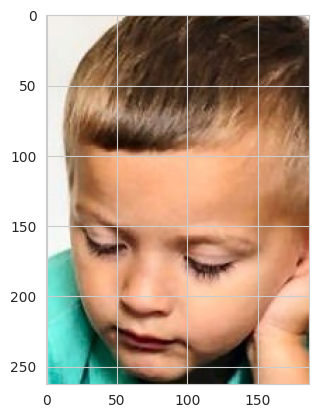

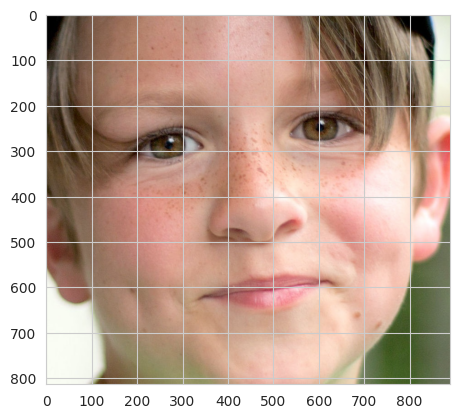

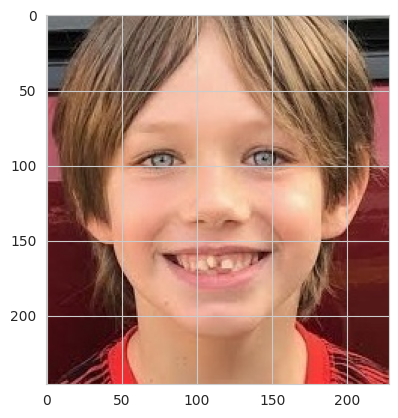

In [38]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [39]:
# Set the dimensions for images
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []

    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)

    return X,y

In [6]:
# Get resized images and labels from train data
X_train, y_train = read_and_process_image(train_imgs)

# Delete train images to save space
del train_imgs
gc.collect()

6494

Text(0.5, 1.0, 'Train image labels')

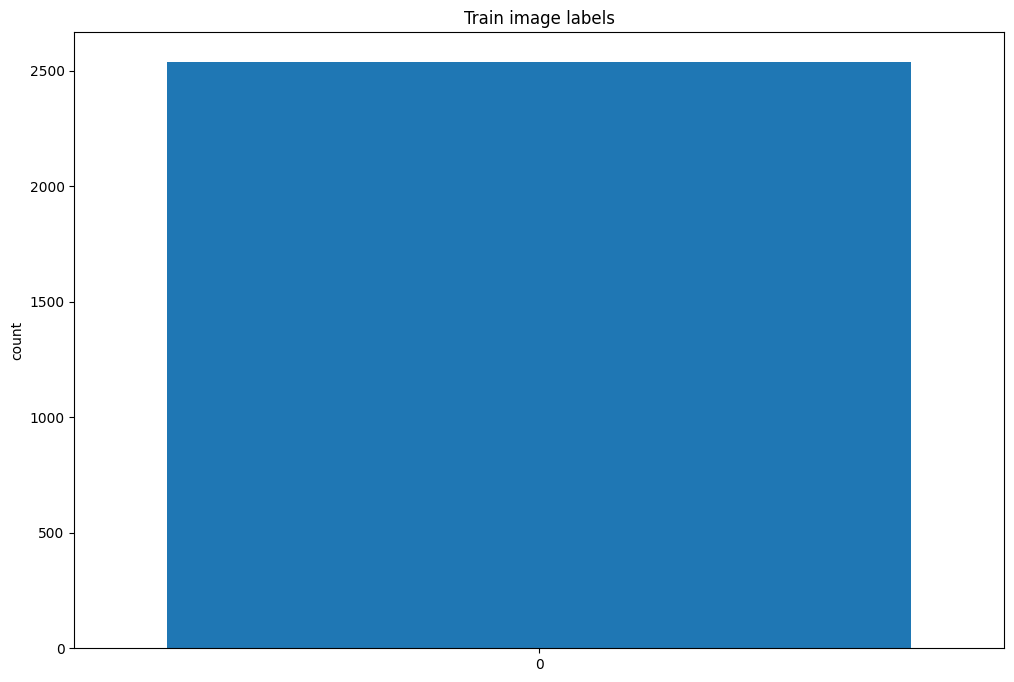

In [7]:
# Convert the lists to array
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)
sns.countplot(y_train, saturation=1)
plt.title("Train image labels")

In [8]:
# Shape of train images and labels
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


In [9]:
# Repeat the above process for validation data to get val_images
val_autistic = "/content/drive/MyDrive/AutismDataset/valid/Autistic"
val_non_autistic = "/content/drive/MyDrive/AutismDataset/valid/Non_Autistic"
val_autistic_imgs = ["/content/drive/MyDrive/AutismDataset/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["/content/drive/MyDrive/AutismDataset/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

15

In [10]:
# Get resized images and labels from validation data
X_val, y_val = read_and_process_image(val_imgs)

# Delete validation images to save space
del val_imgs
gc.collect()

0

Text(0.5, 1.0, 'Validation image labels')

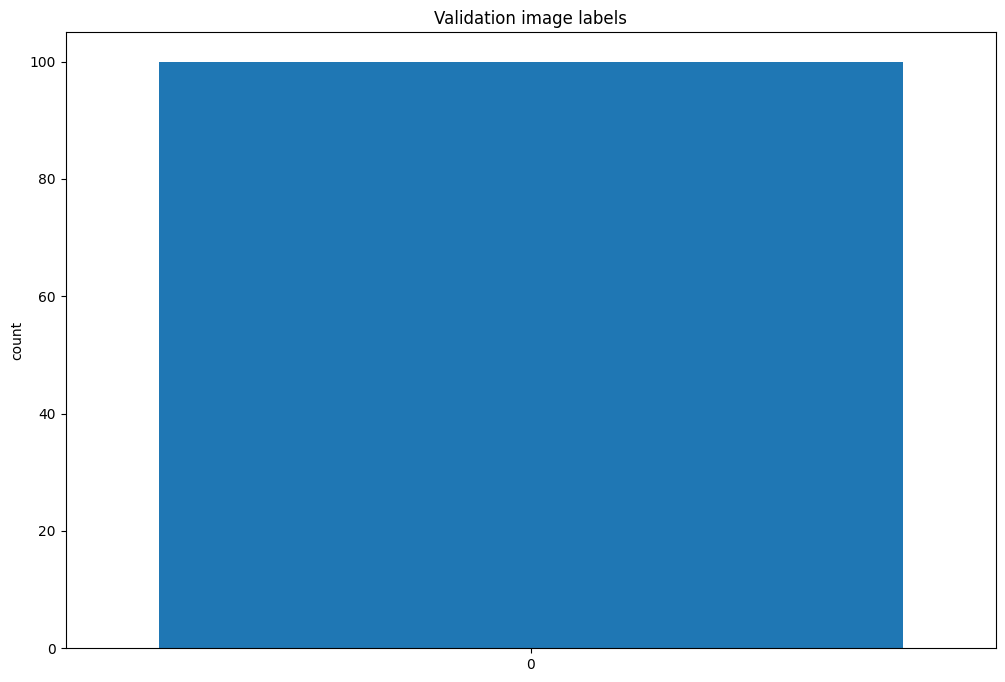

In [11]:
# Convert the lists to array
plt.figure(figsize=(12, 8))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

In [12]:
# Shape of validation images and labels
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


In [13]:
# Get length of train data and validation data
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

In [14]:
# Calling pre-trained VGG16 model
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
# Freeze the layers in pre-trained model, we don't need to train again
for layer in base_model.layers:
   layer.trainable = False

In [16]:
# Let's see how many layers are in the vgg model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [16]:
# Create our classifier model, connect pre-trained model vgg to our model
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [18]:
# Create summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18910017 (72.14 MB)
Trainable params: 4195329 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Configure data augumentation and scaling of images to prevent overfitting since we have a small train data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
X_test, y_test = read_and_process_image(test_imgs)
del test_imgs
gc.collect()

146

Text(0.5, 1.0, 'Test image labels')

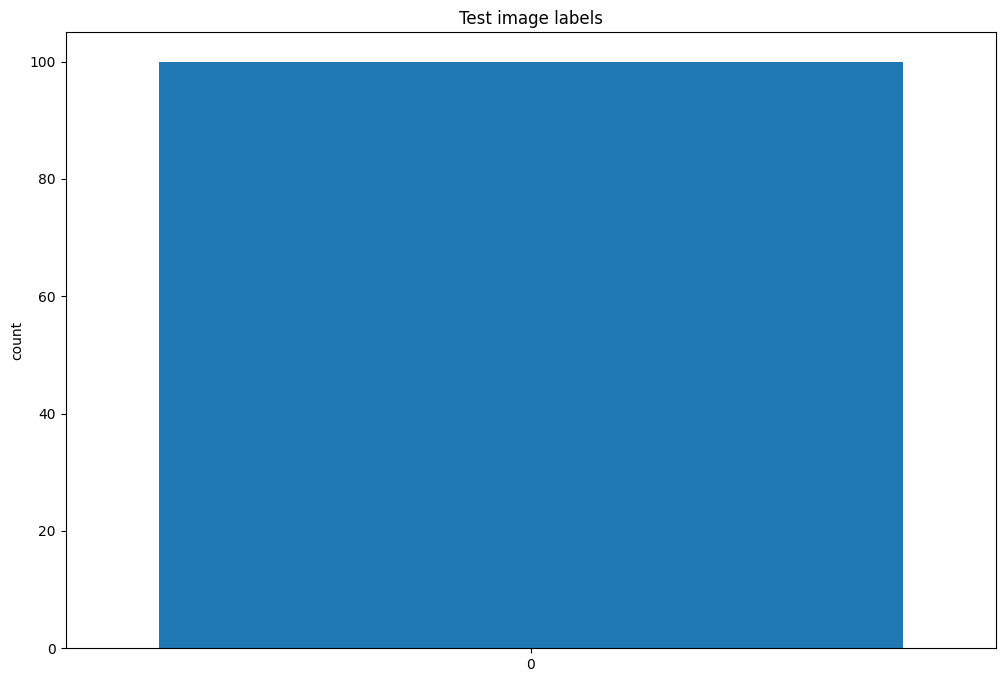

In [22]:
plt.figure(figsize=(12, 8))
X_test = np.array(X_test)
y_test = np.array(y_test)
sns.countplot(y_val, saturation=1)
plt.title("Test image labels")

In [23]:
# Create test and validation image generator
BATCH_SIZE = 64
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
train_generator = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size = BATCH_SIZE)

In [25]:
# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Entrenar el modelo
history = model.fit(train_generator,
                              epochs=10,
                              validation_data=val_generator,
                              callbacks=[early_stopping],
                              workers=8,
                              use_multiprocessing=False
                             )

Epoch 1/10
40/40 [==============================] - 850s 21s/step - loss: 0.7007 - accuracy: 0.6516 - val_loss: 0.5591 - val_accuracy: 0.7400
Epoch 2/10
40/40 [==============================] - 794s 20s/step - loss: 0.5635 - accuracy: 0.7000 - val_loss: 0.5550 - val_accuracy: 0.7000
Epoch 3/10
40/40 [==============================] - 770s 19s/step - loss: 0.5409 - accuracy: 0.7189 - val_loss: 0.5234 - val_accuracy: 0.7500
Epoch 4/10
40/40 [==============================] - 765s 19s/step - loss: 0.5301 - accuracy: 0.7311 - val_loss: 0.5275 - val_accuracy: 0.7200
Epoch 5/10
40/40 [==============================] - 754s 19s/step - loss: 0.5222 - accuracy: 0.7421 - val_loss: 0.5648 - val_accuracy: 0.6900
Epoch 6/10
40/40 [==============================] - 764s 19s/step - loss: 0.5254 - accuracy: 0.7311 - val_loss: 0.5129 - val_accuracy: 0.7400
Epoch 7/10
40/40 [==============================] - 769s 19s/step - loss: 0.5291 - accuracy: 0.7362 - val_loss: 0.5299 - val_accuracy: 0.7300
Epoch 

In [26]:
# Learning curves for training and validation
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.700719,0.651575,0.559112,0.74
1,0.563537,0.700000,0.554959,0.70
2,0.540863,0.718898,0.523354,0.75
3,0.530053,0.731102,0.527497,0.72
4,0.522171,0.742126,0.564785,0.69
5,0.525422,0.731102,0.512900,0.74
6,0.529091,0.736220,0.529888,0.73
7,0.513414,0.738583,0.526632,0.72
8,0.502284,0.749606,0.511559,0.74
9,0.505655,0.753150,0.521650,0.75


Text(0.5, 1.0, 'Training and Validation Accuracy')

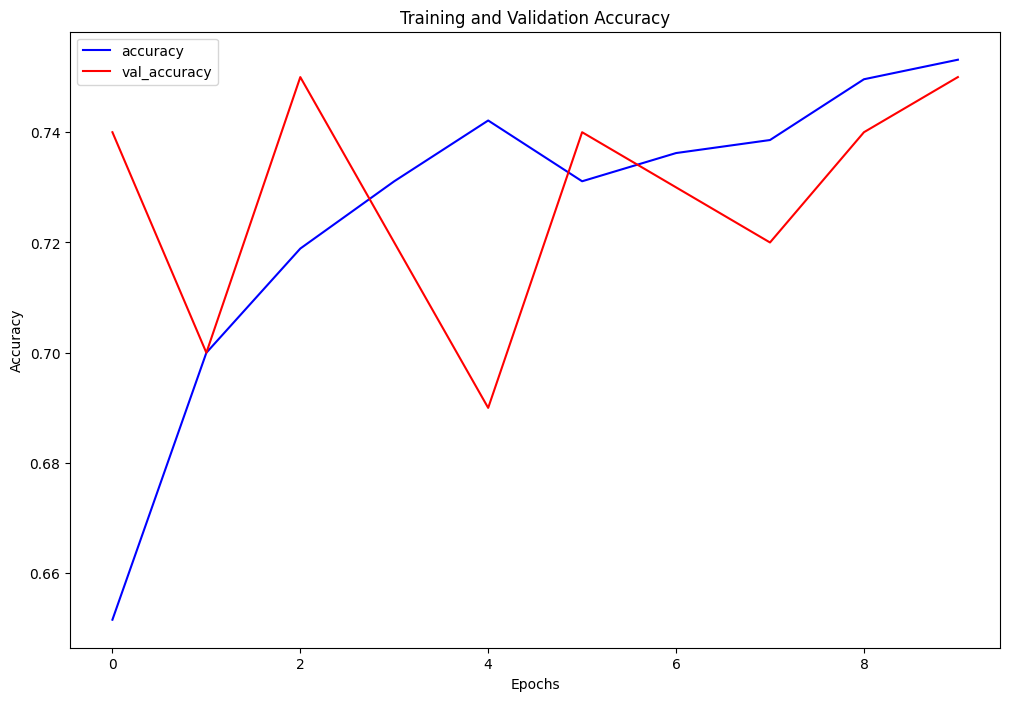

In [27]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["accuracy", "val_accuracy"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

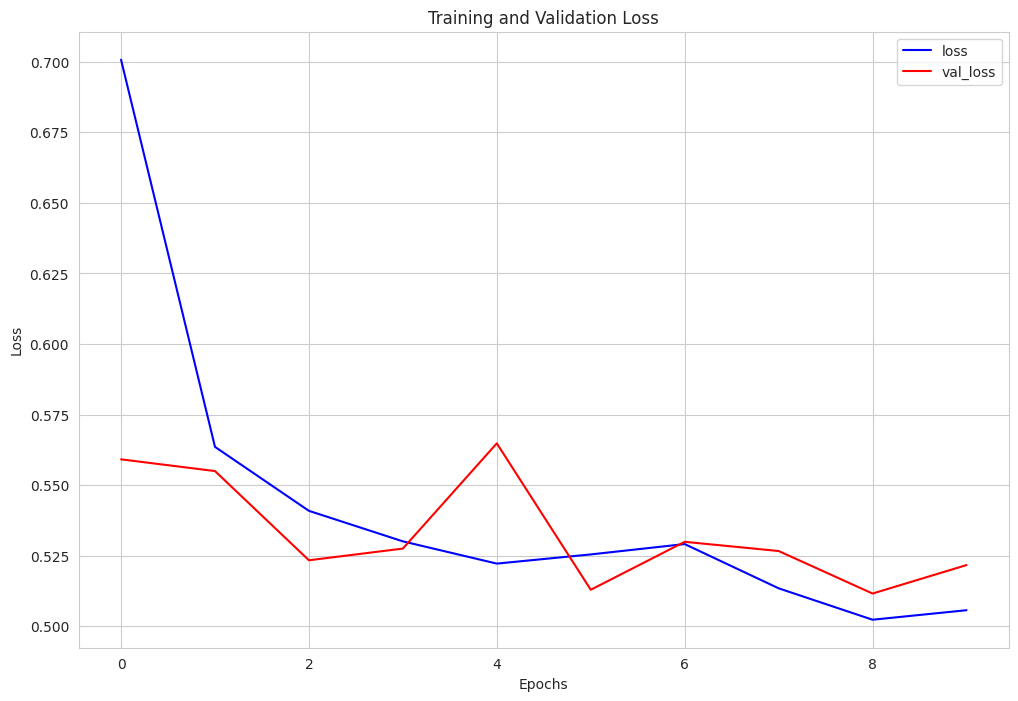

In [28]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [29]:
X = np.array(X_test)

In [30]:
pred = model.predict(X)
threshold = 0.5
predictions = np.where(pred > threshold, 1,0)

10/10 [==============================] - 105s 9s/step


In [33]:
test = pd.DataFrame(data = predictions, columns = ["predictions"])
test
test["filename"] = [os.path.basename(i) for i in test_imgs]
test["test_labels"] = y_test
test = test[["filename", "test_labels", "predictions"]]
test

,filename,test_labels,predictions
0,Autistic.48.jpg,1,1
1,Autistic.120.jpg,1,1
2,Autistic.87.jpg,1,1
3,Autistic.118.jpg,1,0
4,Autistic.115.jpg,1,0
...,...,...,...
295,Non_Autistic.92.jpg,0,0
296,Non_Autistic.35.jpg,0,0
297,Non_Autistic.51.jpg,0,0
298,Non_Autistic.24.jpg,0,1


In [34]:
model_accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))

Model Accuracy: 72.00%


In [35]:
cl_report = classification_report(y_test, predictions)
print(cl_report)

              precision    recall  f1-score   support

           0       0.66      0.91      0.76       150
           1       0.85      0.53      0.66       150

    accuracy                           0.72       300
   macro avg       0.76      0.72      0.71       300
weighted avg       0.76      0.72      0.71       300



In [36]:
cn_matrix= confusion_matrix(y_test, predictions)
cn_matrix

array([[136,  14],
       [ 70,  80]])

Text(0.5, 1.0, 'Confusion Matrix')

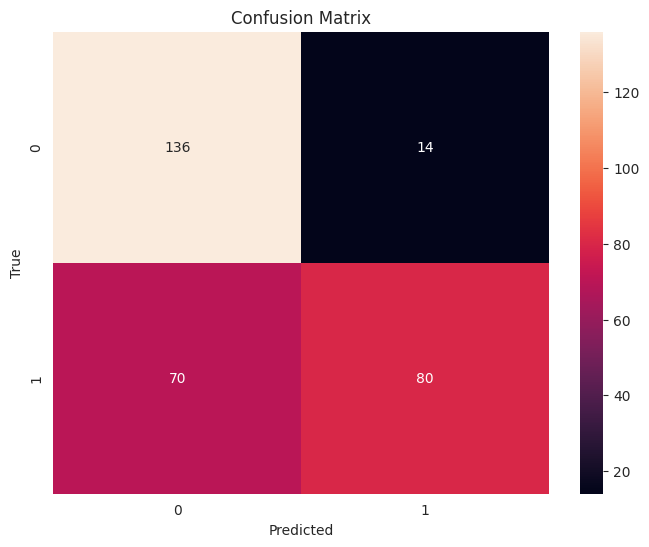

In [37]:
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True,fmt="d")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")